In [1]:
!pip install librosa pandas matplotlib scikit-learn tqdm

In [2]:
import os
import numpy as np
import librosa
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, utils, callbacks
import tensorflow as tf

# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
DATA_PATH = r"F:\Firefox downloader\Projects\Project 2 - Music Genre Indentification\genres"
SAMPLE_RATE = 22050
DURATION = 5  # Seconds per segment
AUDIO_LENGTH = SAMPLE_RATE * DURATION  # 66150 samples
N_CLASSES = 10  # 10 music genres
BATCH_SIZE = 32
EPOCHS = 50


In [23]:
def prepare_dataset(data_path):
    genres = [d for d in os.listdir(data_path) 
             if os.path.isdir(os.path.join(data_path, d))]
    
    features = []
    labels = []
    
    print("Processing audio files...")
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) 
                if f.endswith('.au')]
        
        for file in tqdm(files, desc=genre):
            try:
                # Load and preprocess audio
                y, sr = librosa.load(file, sr=SAMPLE_RATE, duration=DURATION, mono=True)
                
                # Pad/truncate to fixed length
                if len(y) < AUDIO_LENGTH:
                    y = np.pad(y, (0, AUDIO_LENGTH - len(y)))
                else:
                    y = y[:AUDIO_LENGTH]
                
                # Normalize audio
                y = (y - np.mean(y)) / np.std(y)
                features.append(y)
                labels.append(genre)
                
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
    
    return np.array(features), np.array(labels)

# Load and prepare data
X, y = prepare_dataset(DATA_PATH)
print(f"Dataset shape: {X.shape}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = utils.to_categorical(y_encoded, num_classes=N_CLASSES)


Processing audio files...


rock: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 970.64it/s]


Dataset shape: (1000, 110250)


In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# Add channel dimension (1D CNN expects [samples, steps, channels])
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]


Train shape: (800, 110250), Validation shape: (200, 110250)


In [25]:
def build_m5_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(128, 80, strides=4, padding='same', 
                      input_shape=input_shape, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(4),
        
        layers.Conv1D(128, 3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(4),
        
        layers.Conv1D(256, 3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(4),
        
        layers.Conv1D(512, 3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(4),
        
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Build model
input_shape = (AUDIO_LENGTH, 1)
model = build_m5_model(input_shape, N_CLASSES)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 27563, 128)        10368     
                                                                 
 batch_normalization_12 (Bat  (None, 27563, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 6890, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 6890, 128)         49280     
                                                                 
 batch_normalization_13 (Bat  (None, 6890, 128)        512       
 chNormalization)                                                
                                                      

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callback list with proper naming
callback_list = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/50
25/25 [==============================] - 6s 189ms/step - loss: 2.1133 - accuracy: 0.2550 - val_loss: 2.1582 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 4s 176ms/step - loss: 1.7196 - accuracy: 0.3938 - val_loss: 2.4946 - val_accuracy: 0.1650 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 4s 176ms/step - loss: 1.6173 - accuracy: 0.4212 - val_loss: 3.2677 - val_accuracy: 0.1550 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 4s 176ms/step - loss: 1.4557 - accuracy: 0.4550 - val_loss: 4.3862 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 4s 176ms/step - loss: 1.3509 - accuracy: 0.5125 - val_loss: 5.0554 - val_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 6/50
25/25 [==============================] - 4s 177ms/step - loss: 1.2447 - accuracy: 0.5688 - val_loss: 5.2084 - val_accuracy: 0.1550 - lr: 2.0000e-04
Epoch 7/50
25/25 [==============================] - 4s 176ms/s

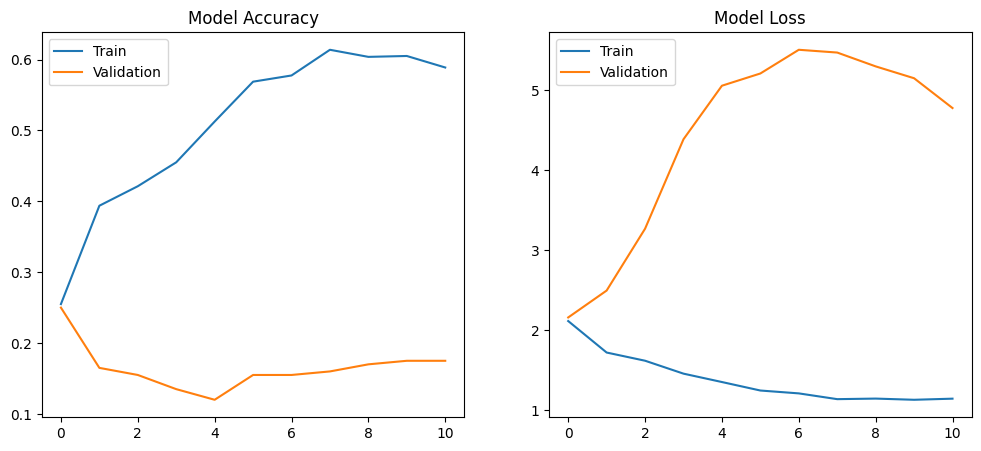

7/7 [==============================] - 0s 47ms/step - loss: 2.1566 - accuracy: 0.2700
Test Accuracy: 0.2700


In [27]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# Load best model for evaluation
model.load_weights("best_model.h5")
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc:.4f}")


In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=le.classes_
))


7/7 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.45      0.65      0.53        20
     country       0.00      0.00      0.00        20
       disco       0.33      0.05      0.09        20
      hiphop       0.19      0.15      0.17        20
        jazz       0.25      0.40      0.31        20
       metal       0.35      0.75      0.48        20
         pop       0.20      0.70      0.31        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.27       200
   macro avg       0.18      0.27      0.19       200
weighted avg       0.18      0.27      0.19       200



C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me